<center> <h2> <b>   Proyecto #2: Chandra</b> </h2>
<br>
<h2> Santiago Lastra Ramírez </h2> </center>
<br>
<center> <h2 style="color: #777; font-size: 15pt; font-style: oblique; "> Minería de Datos </h2>
<h2 style="color: #777; font-size: 15pt; font-style: oblique; "> Intituto de Física - Universidad de Antioquia </h2>  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture as GMM
from scipy.interpolate import CubicSpline,interp1d,splprep,splev
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
import warnings
warnings.filterwarnings("ignore")

%matplotlib nbagg

#plt.style.use('classic')
#plt.style.use(['science','nature'])

plt.rcParams['text.usetex'] = True

# 1.

In [3]:
chandra = pd.read_csv('data/chandra_m83.csv')

# 2.

In [4]:
gaia = pd.read_csv('data/gaia_m83.csv')

# 3.

In [5]:
match = pd.read_csv('data/match.csv')

# 4.

<IPython.core.display.Javascript object>


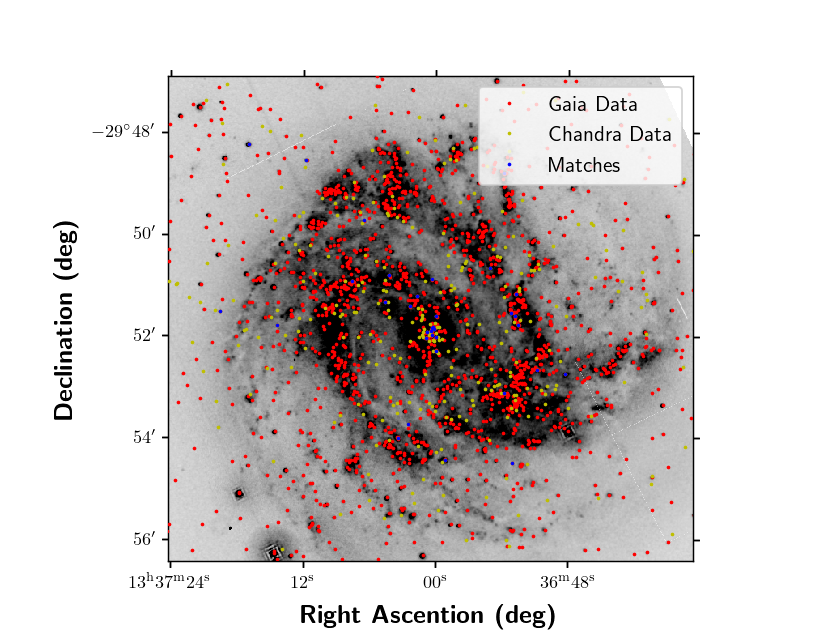

In [6]:
filename = get_pkg_data_filename('data/im1.FTZ')

hdu = fits.open(filename)[0]
wcs = WCS(hdu.header)

ra1,dec1 = wcs.all_world2pix(gaia['RA_ICRS'], gaia['DE_ICRS'], 1)
ra2,dec2 = wcs.all_world2pix(chandra['RAICRS'], chandra['DEICRS'], 1)
ra3,dec3 = wcs.all_world2pix(match['RAICRS'], match['DEICRS'], 1)

plt.figure(dpi=120)
plt.subplot(projection=wcs)
plt.imshow(hdu.data, vmax=0.09, origin='lower',cmap=plt.cm.get_cmap('gray').reversed(), interpolation='nearest')
plt.xlim(450,1100)
plt.ylim(400,1000)
plt.plot(ra1,dec1,'ro',markersize=1,label='Gaia Data')
plt.plot(ra2,dec2,'yo',markersize=1,label='Chandra Data')
plt.plot(ra3,dec3,'bo',markersize=1,label='Matches')
plt.xlabel(r'\textbf{Right Ascention (deg)}', fontsize = 14)
plt.ylabel(r'\textbf{Declination (deg)}', fontsize = 14)
plt.legend(fontsize=12)
#plt.savefig('figs/gaia_chandra.png',dpi=400,bbox_inches='tight')
plt.show()

# 5.

In [7]:
def gauss(data,k,par=['RA_ICRS','DE_ICRS']):

    X = data[par]

    gmm = GMM(k, covariance_type='full', random_state=0)

    gmm.fit(X)

    label = gmm.predict(X)
    
    return(label)

def centers_(df,r,k,par=['RA_ICRS','DE_ICRS']):
    
    data = df[df._r<r]
    
    label = gauss(data,k,par)
    
    centers = np.zeros((k,2))

    for i in range(k):
    
        centers[i] = np.mean(data[label==i][par[0]]),np.mean(data[label==i][par[1]])
        
    return(data,label,centers)

def polar(x,y,a=1): 
    
    r = np.sqrt(x**2+y**2)
    θ0 = np.arctan2(y,x)
    θ = θ0*(θ0>0) + (θ0+2*np.pi)*(θ0<0)
    
    if a==0: return(r,np.rad2deg(θ))
    
    return(r,θ)

def cartesian(r,θ,a=1):
    
    if a==0: θ=np.deg2rad(θ)
    
    x = r*np.cos(θ) 
    y = r*np.sin(θ) 
    
    return(x,y)

## 5.1 Fit con Gaia

<IPython.core.display.Javascript object>


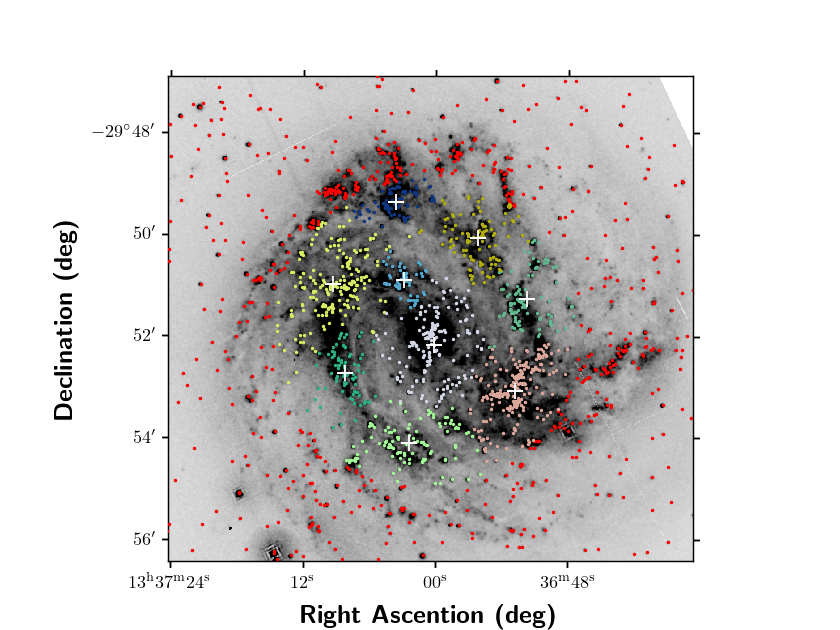

In [8]:
x0,y0 = 204.2536833074599,-29.8655385706900

k = 9

rad = 3  #arcmin

data,label,centers = centers_(gaia,rad,k)

ra_out = gaia[gaia['_r']>rad]['RA_ICRS']
dec_out = gaia[gaia['_r']>rad]['DE_ICRS']

ra_out,dec_out = wcs.all_world2pix(ra_out,dec_out,1)
cx,cy = wcs.all_world2pix(centers[:,0],centers[:,1],1)

plt.figure(dpi=120)
plt.subplot(projection=wcs)
plt.xlim(450,1100)
plt.ylim(400,1000)
plt.imshow(hdu.data, vmax=0.1, origin='lower',cmap=plt.cm.get_cmap('gray').reversed(), interpolation='nearest')
plt.plot(ra_out,dec_out,'ro', markersize = 0.9, )

for i in range(k):
    c = (np.random.random(),np.random.random(),np.random.random())
    ra_,dec_ = wcs.all_world2pix(data[label==i].RA_ICRS,data[label==i].DE_ICRS,1)
    plt.plot(ra_,dec_,'o',color = c, markersize = 0.9)

plt.plot(cx,cy,'w+', markersize=9)
plt.xlabel(r'\textbf{Right Ascention (deg)}', fontsize = 14)
plt.ylabel(r'\textbf{Declination (deg)}', fontsize = 14)
#plt.savefig('figs/groups_gaia.png',dpi=400,bbox_inches='tight')
plt.show()

## 5.1.1 Coordenadas centros (desplazadas)

In [9]:
x = centers[:,0] - x0
y = centers[:,1] - y0

r,θ = polar(x,y,0)

## 5.1.2 Fit Brazo 1.

<IPython.core.display.Javascript object>


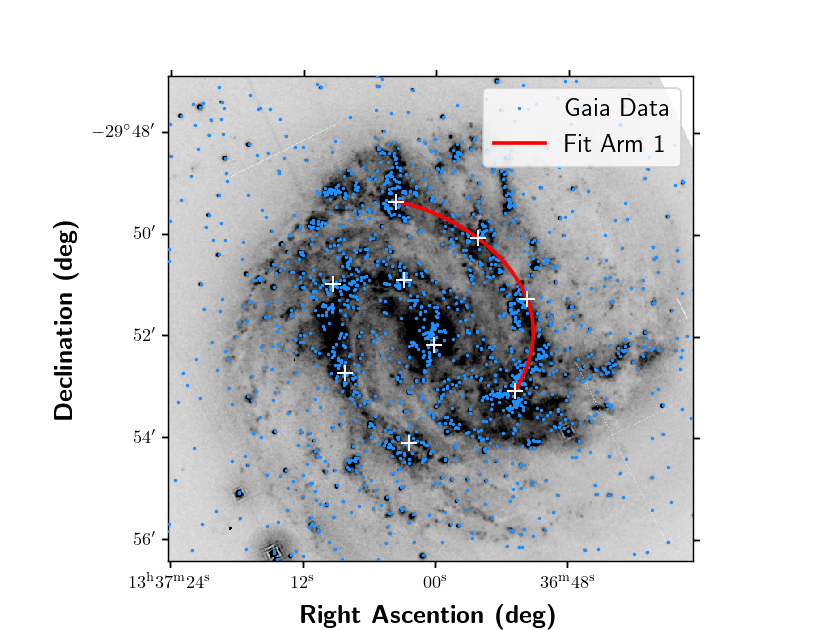

In [10]:
r1 = r[(θ>70)&(θ<210)&(r>0.009)]
θ1 = θ[(θ>70)&(θ<210)&(r>0.009)]

x1,y1 = cartesian(r1,θ1,a=0)

X1 = np.array([x1[3],x1[1],x1[2],x1[0]])
Y1 = np.array([y1[3],y1[1],y1[2],y1[0]])

tck1,u1 = splprep([X1, Y1], s=0, per=False)

xi1,yi1 = splev(np.linspace(0, 1, 1000), tck1)

xi1,yi1 = wcs.all_world2pix(xi1+x0,yi1+y0,1)

centersx,centersy = wcs.all_world2pix(centers[:,0],centers[:,1],1)

plt.figure(dpi=120)
plt.subplot(projection=wcs)
plt.imshow(hdu.data, vmax=0.1, origin='lower',cmap=plt.cm.get_cmap('gray').reversed(), interpolation='nearest')
plt.xlim(450,1100)
plt.ylim(400,1000)
plt.plot(ra1,dec1,'o',color='dodgerblue',markersize=0.9,label='Gaia Data')
plt.plot(xi1, yi1, color='red', linewidth=2,label = 'Fit Arm 1')
plt.plot(centersx,centersy,'w+', markersize=9)
plt.xlabel(r'\textbf{Right Ascention (deg)}', fontsize = 14)
plt.ylabel(r'\textbf{Declination (deg)}', fontsize = 14)
plt.legend(fontsize=14)
#plt.savefig('figs/arm1.png',dpi=400,bbox_inches='tight')
plt.show()

## 5.1.3 Fit Brazo 2.

<IPython.core.display.Javascript object>


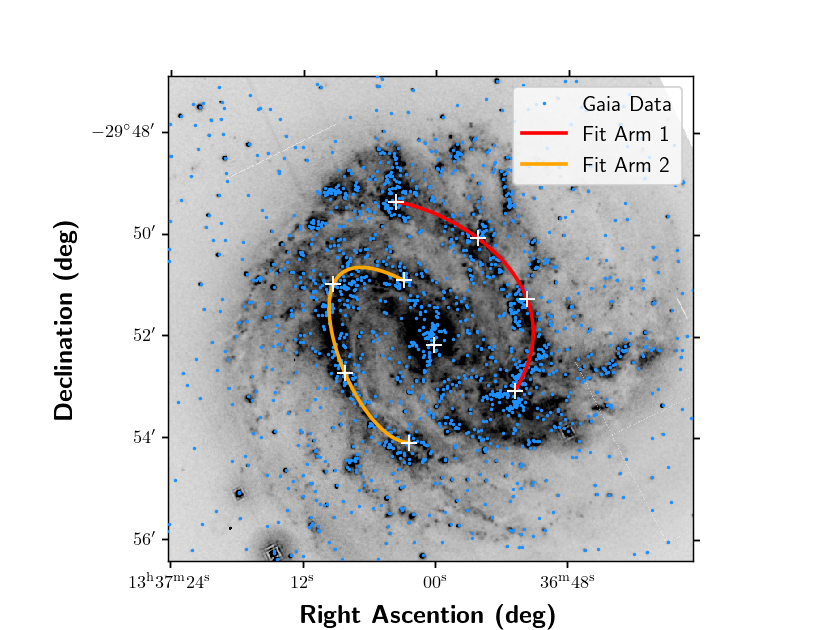

In [11]:
r2 = r[(θ<70)|(θ>210)]
θ2 = θ[(θ<70)|(θ>210)]

x2,y2 = cartesian(r2,θ2,a=0)

X2 = np.array([x2[4],x2[1],x2[3],x2[0]])
Y2 = np.array([y2[4],y2[1],y2[3],y2[0]])

tck2,u2 = splprep([X2, Y2], s=0, per=False)

xi2,yi2 = splev(np.linspace(0, 1, 1000), tck2)

xi2,yi2 = wcs.all_world2pix(xi2+x0,yi2+y0,1)

plt.figure(dpi=120)
plt.subplot(projection=wcs)
plt.imshow(hdu.data, vmax=0.1, origin='lower',cmap=plt.cm.get_cmap('gray').reversed(), interpolation='nearest')
plt.xlim(450,1100)
plt.ylim(400,1000)
plt.plot(ra1,dec1,'o',color='dodgerblue',markersize=0.9,label='Gaia Data')
plt.plot(xi1, yi1, color='red', linewidth=2,label = 'Fit Arm 1')
plt.plot(xi2, yi2, color='orange', linewidth=2,label = 'Fit Arm 2')
plt.plot(centersx,centersy,'w+', markersize=9)
plt.xlabel(r'\textbf{Right Ascention (deg)}', fontsize = 14)
plt.ylabel(r'\textbf{Declination (deg)}', fontsize = 14)
plt.legend(fontsize=12)
#plt.savefig('figs/arm2.png',dpi=400,bbox_inches='tight')
plt.show()

## 5.2 Fit con Chandra.

<IPython.core.display.Javascript object>


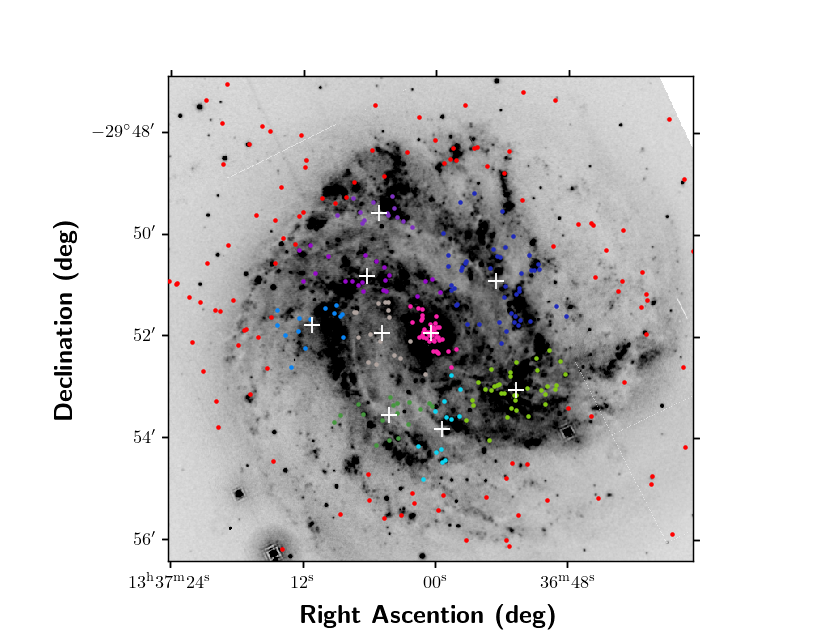

In [12]:
x0,y0 = 204.2536833074599,-29.8655385706900

k1 = 9

rad1 = 3  #arcmin

s = 1.5

par = ['RAICRS','DEICRS']

data1,label1,centers1 = centers_(chandra,rad1,k1,par)

ra_out1 = chandra[chandra['_r']>rad1]['RAICRS']
dec_out1 = chandra[chandra['_r']>rad1]['DEICRS']

ra_out1,dec_out1 = wcs.all_world2pix(ra_out1,dec_out1,1)
cx1,cy1 = wcs.all_world2pix(centers1[:,0],centers1[:,1],1)

plt.figure(dpi=120)
plt.subplot(projection=wcs)
plt.xlim(450,1100)
plt.ylim(400,1000)
plt.imshow(hdu.data, vmax=0.1, origin='lower',cmap=plt.cm.get_cmap('gray').reversed(), interpolation='nearest')
plt.plot(ra_out1,dec_out1,'ro', markersize = 1.5)

for i in range(k):
    c = (np.random.random(),np.random.random(),np.random.random())
    ra_1,dec_1 = wcs.all_world2pix(data1[label1==i].RAICRS,data1[label1==i].DEICRS,1)
    plt.plot(ra_1,dec_1,'o',color = c, markersize = s)

plt.plot(cx1,cy1,'w+', markersize=9)
plt.xlabel(r'\textbf{Right Ascention (deg)}', fontsize = 14)
plt.ylabel(r'\textbf{Declination (deg)}', fontsize = 14)
#plt.savefig('figs/groups_chandra.png',dpi=400,bbox_inches='tight')
plt.show()